<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Quantum Error Correction

In this tutorial, we discuss the nature of errors present in qubits. We then derive and implement a circuit that attacks the special case where the error in a qubit is a complete bit flip. 

***
## Contributors

Andrew Selzler, Yin Li, Frederick Ira Moxley III

## Introduction

Through any quantum computation, errors become present in qubits through thermal fluctuations, mechanical vibrations or other interactions between whatever the qubits are made out of and the environment around them. The state of the qubits then morphs into one that it was not supposed to be and ruins the computation further down the line. Because of this, the concept of quantum error correction is very neccesary to achieve future advancements in quantum computing. A question that may be raised is how does one correct for errors in qubits if they have to measure the qubits to see what the errors are. And if this is done, how is the state of the qubit preserved after the measurement which should have destroyed it? 

Very clever methods have been developed by people over the years to attack this issue. The idea that we will be exploring involves the use of "ancilla" qubits. These are qubits that are placed in the same circuit as the qubits involved in the actual computation. If the state of the qubits involved in the computation are changed through unwanted interaction with the environment, the ancilla qubits will also be changed in such a way that if we were to measure the ancilla qubits, they would give the needed information about what errors were produced in the qubits involved in computation. We would then be able to recover the states of those qubits accordingly without needing or having any information about what those states actually are. 

As stated earlier we will be looking at the simple (but somewhat unrealistic) case where the error produced in qubits is a complete bit flip. This corresponds to an X gate being added unwantingly to the circuit and flipping the state of the affected qubit. 

## Circuit and Code

We will begin the strategy by taking one qubit worth of information and encoding it into three actual qubits. These three qubits are known as codewords. This can be done by introducing the states $\vert \tilde0 \rangle = \vert 000 \rangle$ and $\vert \tilde1 \rangle = \vert 111 \rangle$. Then, a superposition of the two states can be created as $\alpha \vert 000 \rangle + \beta \vert 111 \rangle$. One might create this state on a machine through the use of CNOT gates as shown in the below picture.

In [1]:
from IPython.display import Image

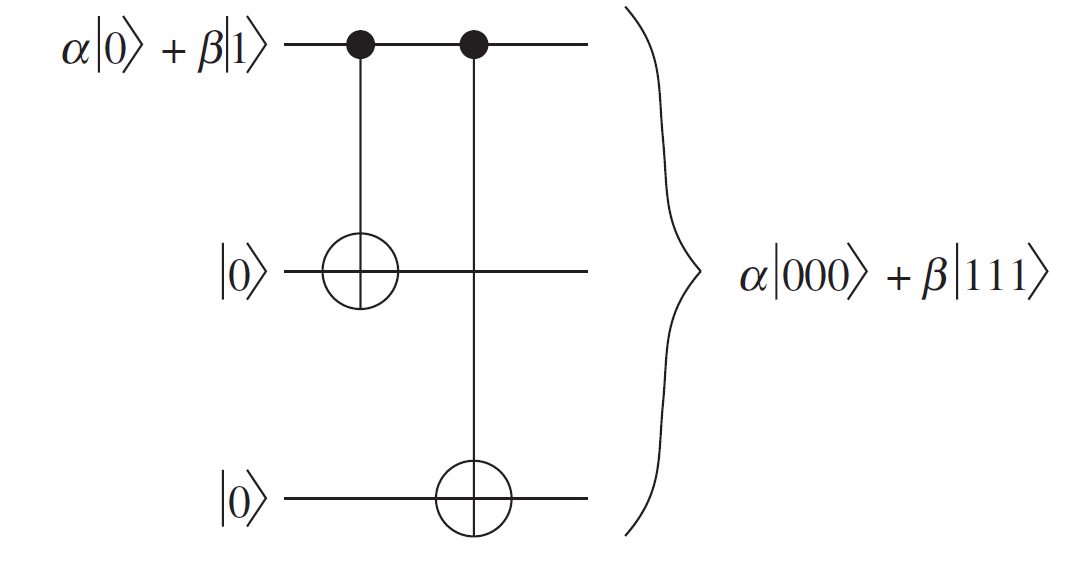

In [2]:
Image(filename="error_correction_files/error_correction_1_0.png", width=450, height=300)

It is easy to confirm that this circuit takes $\vert 000 \rangle$ to $\vert 000 \rangle$ and $\vert 100 \rangle$ to $\vert 111 \rangle$. Since the circuit works for those two basis states, it will also work for any superposition of those two basis states due to the linearity of quantum circuits. This idea of linearity will be used often throughout this notebook.

Now suppose that an unwanted X gate has been applied to one of these three qubits. This can be seen in the below picture where the X gates with the jagged borders represent these errors.  

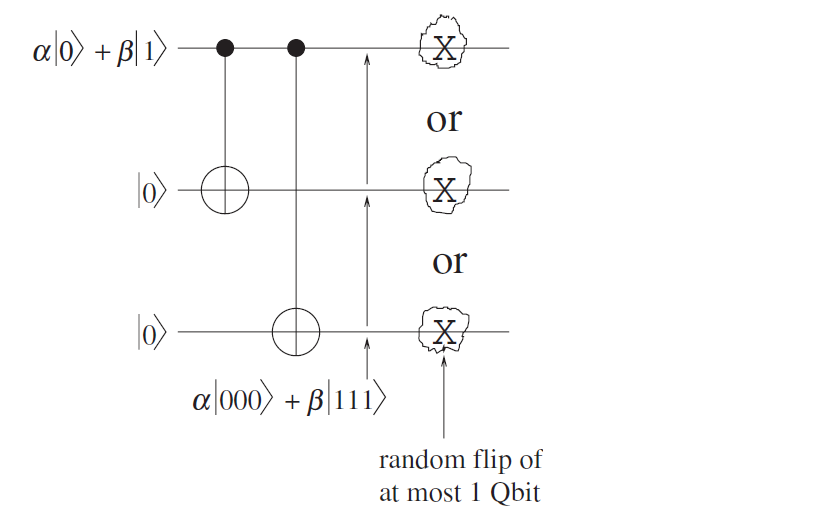

In [3]:
Image(filename="error_correction_files/error_correction_3_0.png", width=450, height=300)   

Note: it is safe to assume that only one of the three qubits will be affected. This is because if the probability of any one of the three qubits being affected by an unwanted X gate is sufficiently low in a given time interval, the probability of two or more qubits being affected in that same interval is negligible.

How can we detect that one of the three qubits has been affected by an unwanted X gate? This is where the ancilla qubits come into play. Consider the circuit shown below.

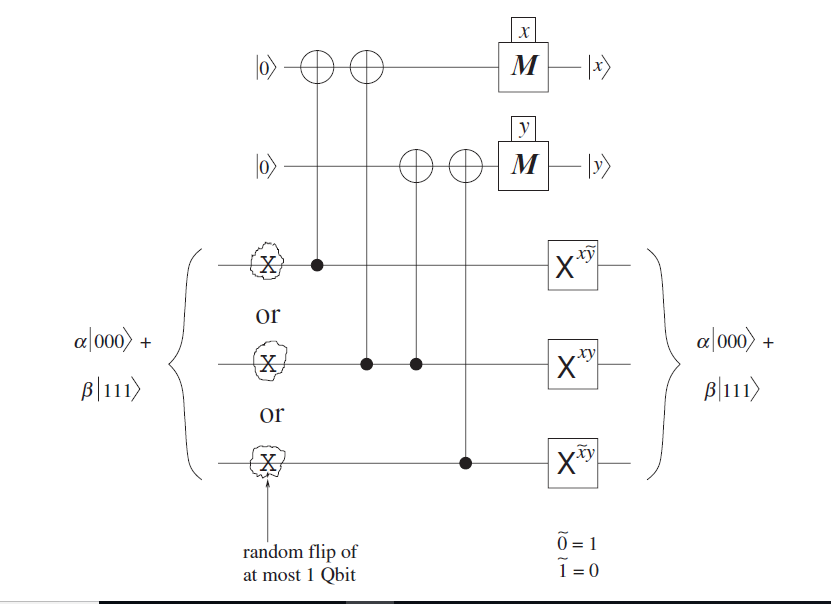

In [4]:
Image(filename="error_correction_files/error_correction_5_0.png", width=450, height=300)  

In this circuit the top two qubits are the ancilla qubits and the bottom three qubits are the codewords for the qubit involved in the calculation. Now suppose that $\alpha$ is equal to 1 and $\beta$ is equal to zero so that the initial state is $\vert 000 \rangle$. Depending on which qubit gets affected by the unwanted X gate (or if no qubit gets affected at all), the state can end up as one of four possibilities, $\vert 000 \rangle$, $\vert 100 \rangle$, $\vert 010 \rangle$, and $\vert 001 \rangle$. The ancilla qubits are initially in the state $\vert 00 \rangle$. When the three codeword qubits pass through the next four CNOT gates, one can confirm that with the four possible states of the three codeword qubits listed, the ancilla qubits will take the four possible states $\vert 00 \rangle$, $\vert 10 \rangle$, $\vert 11 \rangle$, and $\vert 01 \rangle$ respectively. 

Amazingly, these four states would appear in the same order if the initial state of the three codeword qubits was $\vert 111 \rangle$ instead. For example if the first of the three codeword qubits were flipped, the state of the ancilla qubits would end up as $\vert 10 \rangle$ whether the initial state of the three codeword qubits was $\vert 000 \rangle$ or $\vert 111 \rangle$. This means that the ancilla qubits would end up the same way for any initial superposition $\alpha \vert 000 \rangle + \beta \vert 111 \rangle$ of the three codeword qubits again due to the linearity of the circuit.

Now when the ancilla qubits are measured, x is the result of the first qubit and y is the result of the second qubit. These results are then used to determine how many times (either 0 or 1) each of the three codeword qubits will be flipped by another X gate. Suppose for example that the first of the three codeword qubits got flipped by an unwanted X gate in the beginning. Then the ancilla qubits would be affected so that x is equal to 1 and y is equal to 0. Then $x \tilde y = 1$, $xy = 0$, and $\tilde x y = 0$. This means the first codeword qubit is the only one that gets flipped at this stage, which is good since it is the first codeword qubit that received the error to begin with. One can check with this circuit that with an initial state $\alpha \vert 000 \rangle + \beta \vert 111 \rangle$, any qubit that gets flipped by an unwanted X gate ends up getting flipped back by the final three X gates, which means this circuit succeeds in correcting for any bit flip error produced in the three codeword qubits.

It would be nice however, to create a circuit that performs the same task as above but does not rely on the results of measuring the ancilla qubits partway through. The circuit that does this, which is also the circuit that we will be implementing in this notebook is shown below. 

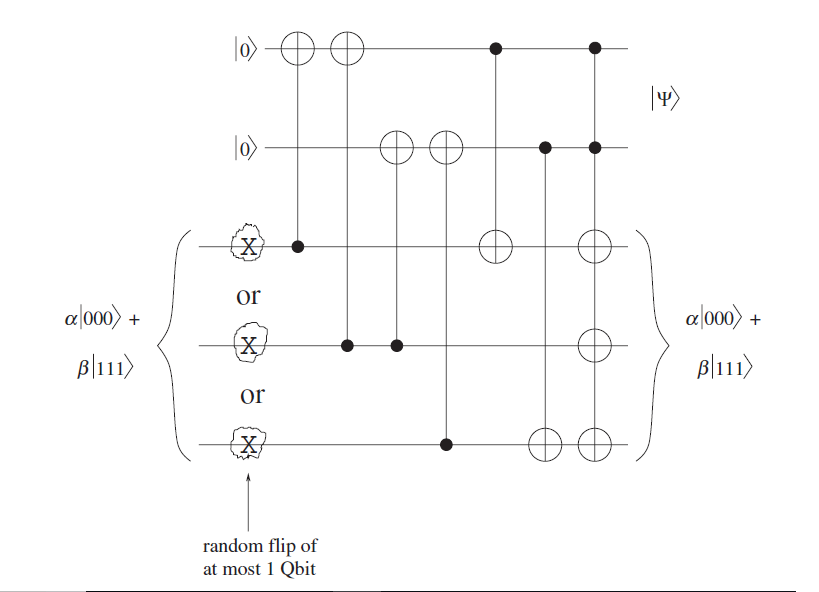

In [5]:
Image(filename="error_correction_files/error_correction_7_0.png", width=450, height=300)    

The measurements and X gates are replaced with CNOT gates and a double toffoli gate acting on all three codeword qubits. The function of this last gate is to flip all three codeword qubits if the ancilla qubits are in the state $\vert 11 \rangle$ and do nothing otherwise. With this, we are ready to use qiskit to actually create the circuit.

In [6]:
# import useful packages
import os
import shutil

# importing Qiskit
from qiskit import Aer, execute
from qiskit.backends.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# Needed to visualize quantum circuits

from IPython.display import Image
from qiskit.tools.visualization import circuit_drawer, plot_histogram

In [7]:
# Circuit requires 5 qubits and 5 classical bits
quantum_r = QuantumRegister(5, name='qr')
classical_r = ClassicalRegister(5, name='cr')
# Create quantum circuit
circuit = QuantumCircuit(quantum_r, classical_r, name='circuit')

In [8]:
def toffoli(circuit,quantum_r,a,b,c):
    """
    Creates toffoli gate in existing circuit with a and b 
    as the test points and c as the affected point
    """
    circuit.iden(quantum_r[c])
    circuit.h(quantum_r[c])
    circuit.cx(quantum_r[b],quantum_r[c])
    circuit.tdg(quantum_r[c])
    circuit.cx(quantum_r[a],quantum_r[c])
    circuit.t(quantum_r[c])
    circuit.cx(quantum_r[b],quantum_r[c])
    circuit.tdg(quantum_r[c])
    circuit.cx(quantum_r[a],quantum_r[c])
    circuit.t(quantum_r[c])
    circuit.t(quantum_r[b])
    circuit.h(quantum_r[c])
    circuit.cx(quantum_r[b],quantum_r[c])
    circuit.h(quantum_r[c])
    circuit.h(quantum_r[b])
    circuit.cx(quantum_r[b],quantum_r[c])
    circuit.h(quantum_r[c])
    circuit.h(quantum_r[b])
    circuit.cx(quantum_r[b],quantum_r[c])
    circuit.cx(quantum_r[a],quantum_r[c])
    circuit.t(quantum_r[a])
    circuit.tdg(quantum_r[c])
    circuit.cx(quantum_r[a],quantum_r[c])
    circuit.cx(quantum_r[b],quantum_r[c])
    circuit.cx(quantum_r[c],quantum_r[b])
    circuit.cx(quantum_r[b],quantum_r[c])

Below is the code to add the circuit elements. The first three X gates act as the source of error to the codeword qubits. Include or comment out any of the three X gates to see different results of the program. For example, commenting out the third X gate would leave the codeword qubits in the state  |110⟩|110⟩ . This should correspond to an initial state of  |111⟩|111⟩  with a bit flip error introduced in the third qubit, which means the output of the three codeword qubits should be  |111⟩|111⟩  if everything worked properly.

Next are the CNOT gates that make the circuit and the three Toffoli gates. There are three Toffoli gates because the original circuit called for a Toffoli gate that acted on all three qubits. This is equivalent to having three separate Tofolli gates that each act on a different qubit as one can confirm.



In [9]:
#circuit.x(quantum_r[2])
circuit.x(quantum_r[3])
circuit.x(quantum_r[4])

circuit.cx(quantum_r[2],quantum_r[0])
circuit.cx(quantum_r[3],quantum_r[0])
circuit.cx(quantum_r[3],quantum_r[1])
circuit.cx(quantum_r[4],quantum_r[1])

circuit.cx(quantum_r[0],quantum_r[2])
circuit.cx(quantum_r[1],quantum_r[4])
toffoli(circuit,quantum_r,0,1,2)
toffoli(circuit,quantum_r,0,1,3)
toffoli(circuit,quantum_r,0,1,4)

circuit.measure(quantum_r[0], classical_r[0])
circuit.measure(quantum_r[1], classical_r[1])
circuit.measure(quantum_r[2], classical_r[2])
circuit.measure(quantum_r[3], classical_r[3])
circuit.measure(quantum_r[4], classical_r[4])

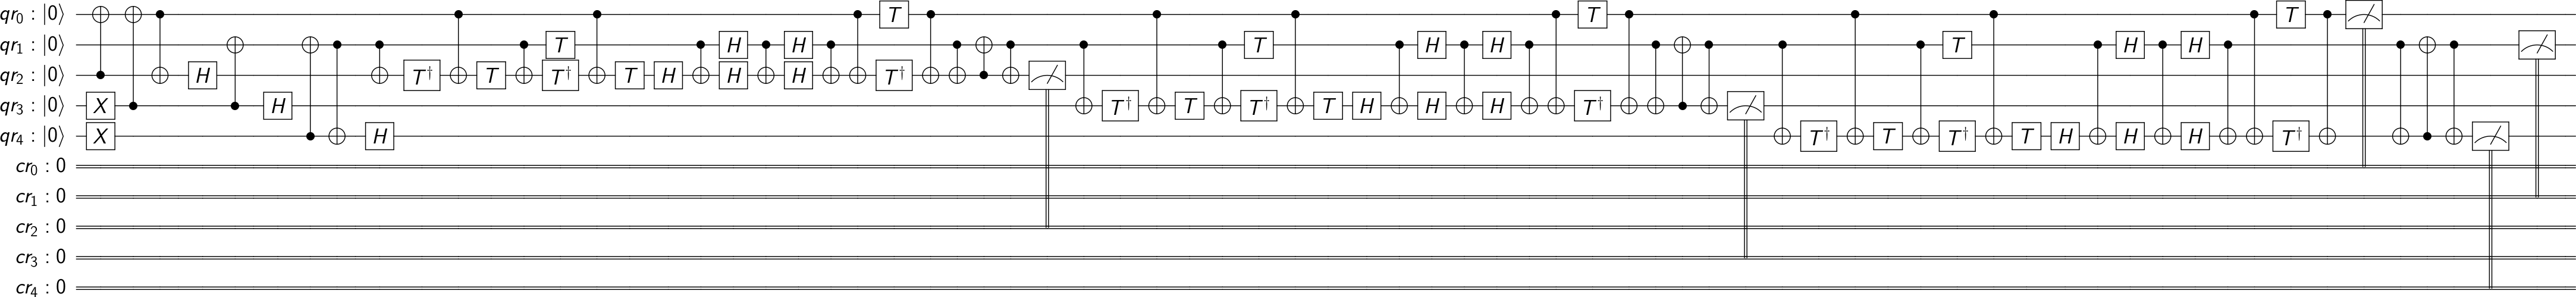

In [10]:
# plot the circuit
circuit_drawer(circuit)

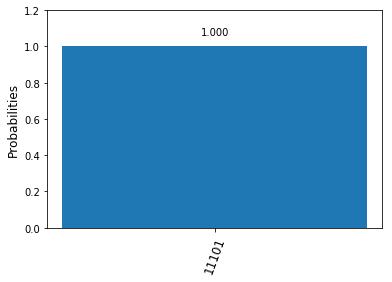

In [11]:
"""
Results of the computation. Note that the states of the five qubits
from up to down in the circuit are shown from right to left in the result. 
"""
# use local qasm simulator
backend = Aer.get_backend('qasm_simulator')

result = execute(circuit, backend=backend, shots=1024).result()
plot_histogram(result.get_counts())

# Grover's Algorithm

In this section, we discussed implementing the Grover's algorithm on 3 qubits, where we have the initialization stage, the oracle stage, and the amplification stage. We showed that using one cycle of the Grover's algorithm, we could get the probability of each output state to be roughly 70%, and that using two cycles, we could get it to more than 80%

## Introduction

Grover's algorithm is recogonized as the following problem:

Given that we have $$f(x)=0, x \neq a; f(x)=1, x=a.$$ 
We can use Grover's algorithm to find what is the value of a.

The Grover's algorithm is useful for many fields of interests, including searching a database, and finding the median and mean of a set of numbers.

With the help of the tutorila for Grover's algorithm for 2 qubits, we used the IBM Q experience's Qasm editor to implement to Grover's algorithm for 3 qubits.

## Steps to Follow

We followed: Initialization → Oracle → Amplification
We only did the orale-amplification cycle for one round for simplicity in the code. Better effect of Grover's algorithm will be reached by running the cycle for multiple times.

### Initialization

The initialization stage is used to create a superposition of all the possible input states by three Hadamard gates

We started by the following codes in Qasm:

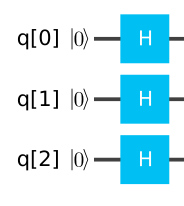

In [12]:
Image(filename="error_correction_files/error_correction_27_0.png", width=250, height=300)   

### Oracle

The Oracle stage marks the desired state by changing the marked state's amplitude to negative while remaining the other states' amplitudes.

Different gate structures denote different marked states, which can be refered to the table below:

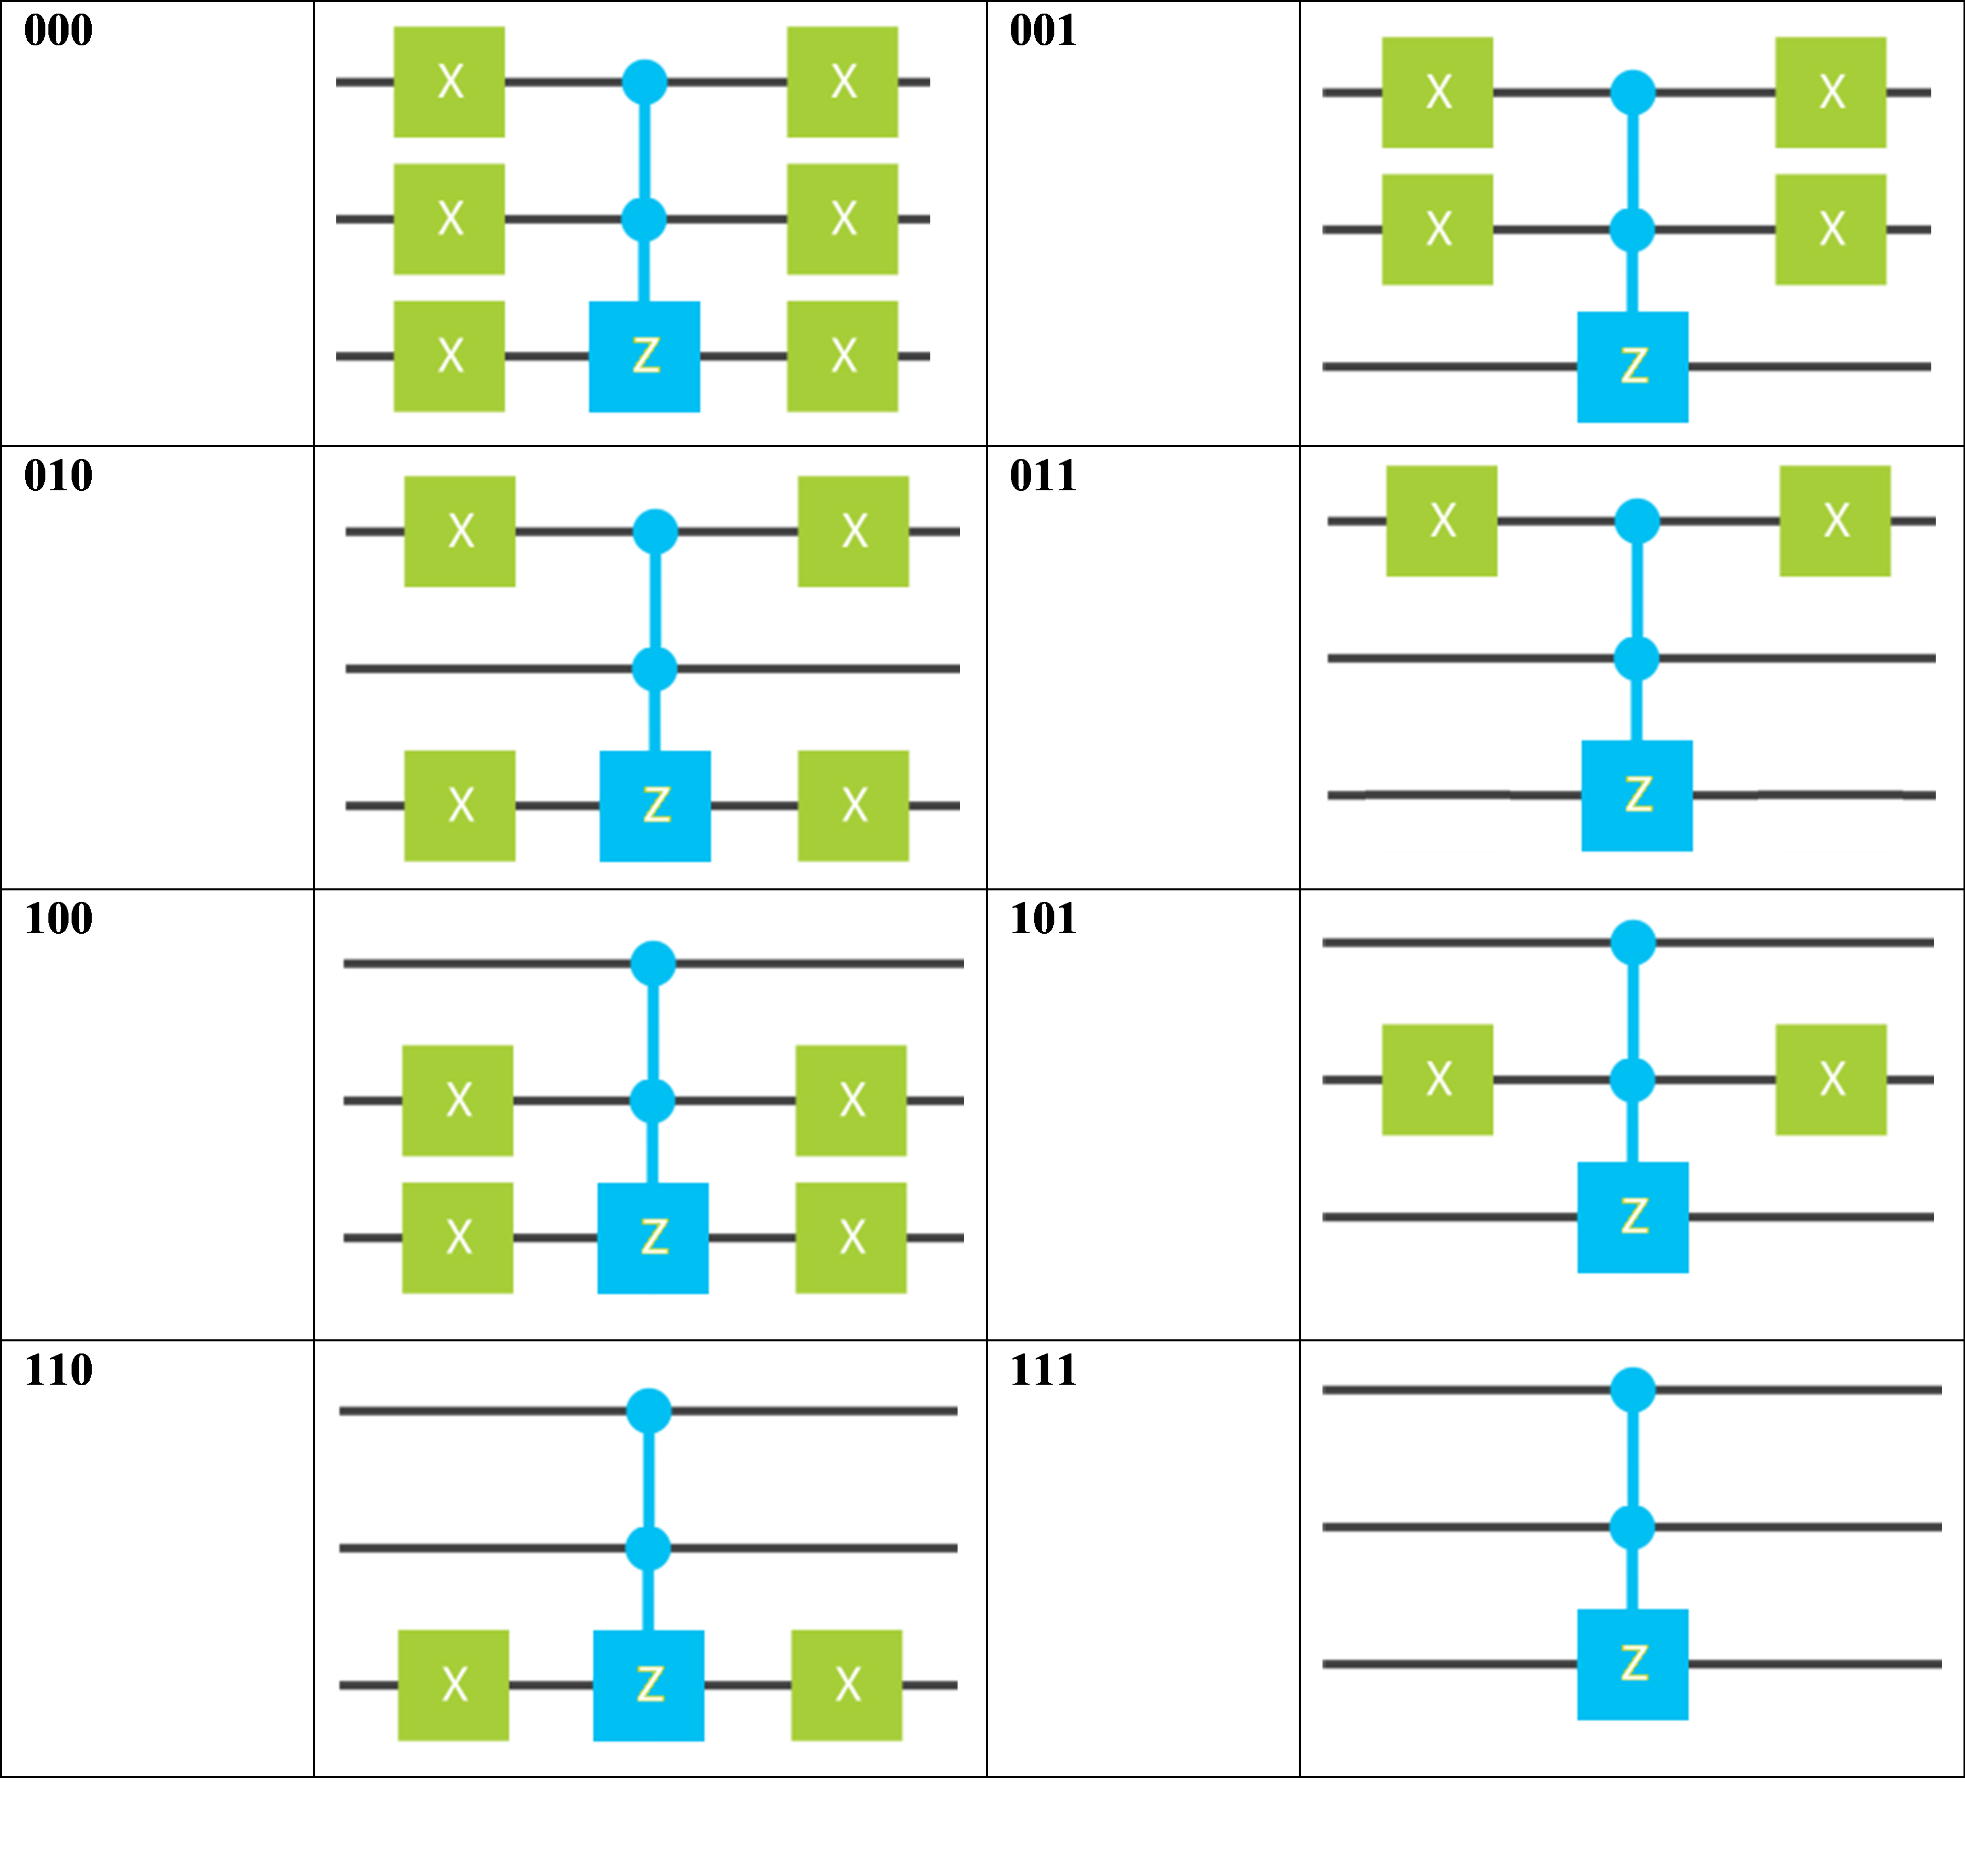

In [13]:
Image(filename="error_correction_files/error_correction_30_0.png", width=450, height=300)

### Amplification

The amplification stage reflects all the states about the mean vector of all the states. As a result, the correct state's magnitude will be maximized.

The Qasm code is shown below

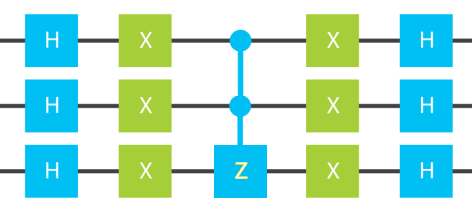

In [14]:
Image(filename="error_correction_files/error_correction_33_0.png", width=450, height=300)

## The CCZ Gate

The CCZ (controlled-controlled-Z) gate does not appear as one of the default gate in the IBM Q experience App. As a result, we implemented by using the controlled-NOT gate, the T gate, and the T conjugate gate.

The Qasm code is shown below

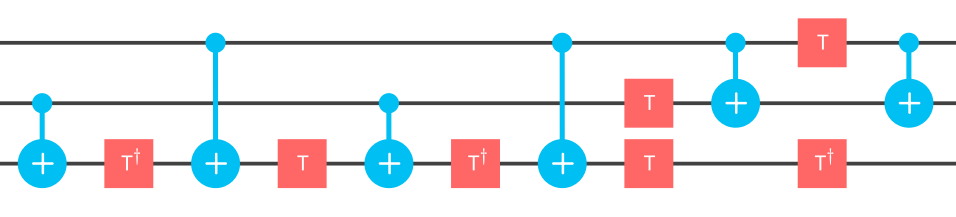

In [15]:
Image(filename="error_correction_files/error_correction_36_0.png", width=450, height=300)

## Sample Result

A sample code of the Grover's algorithm with the marked state 000 is shown below, where we simulated the process and got satisfacting results.

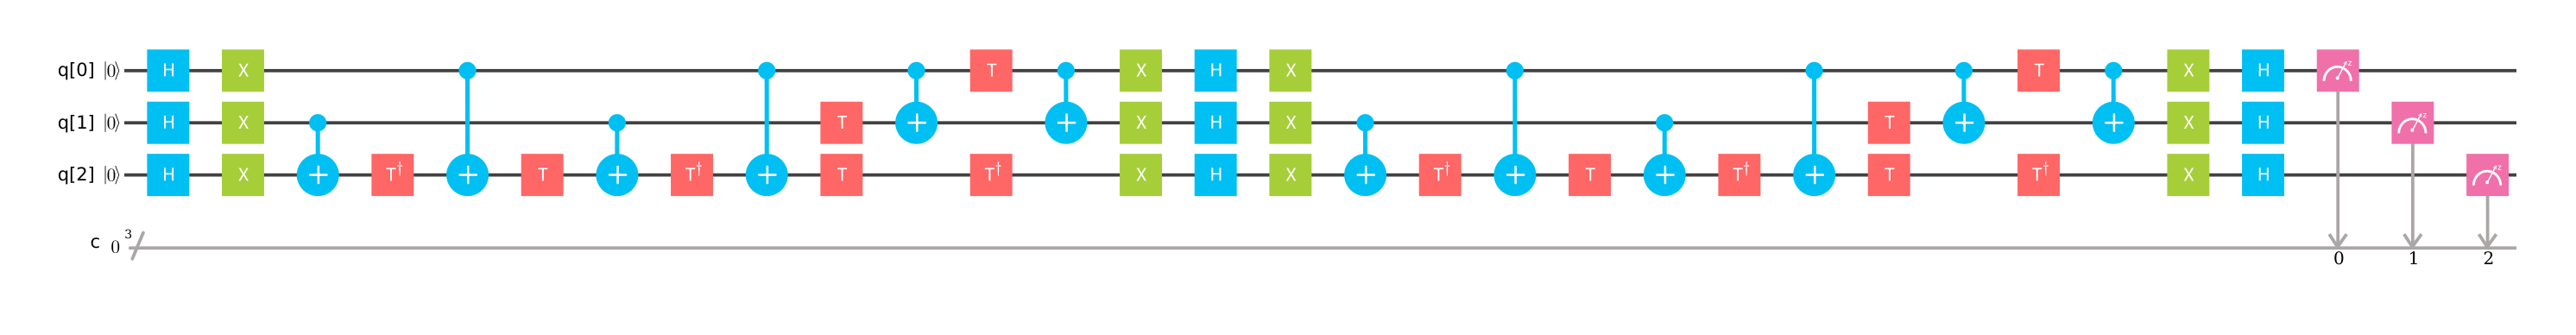

In [16]:
Image(filename="error_correction_files/error_correction_39_0.png", width=900, height=600)

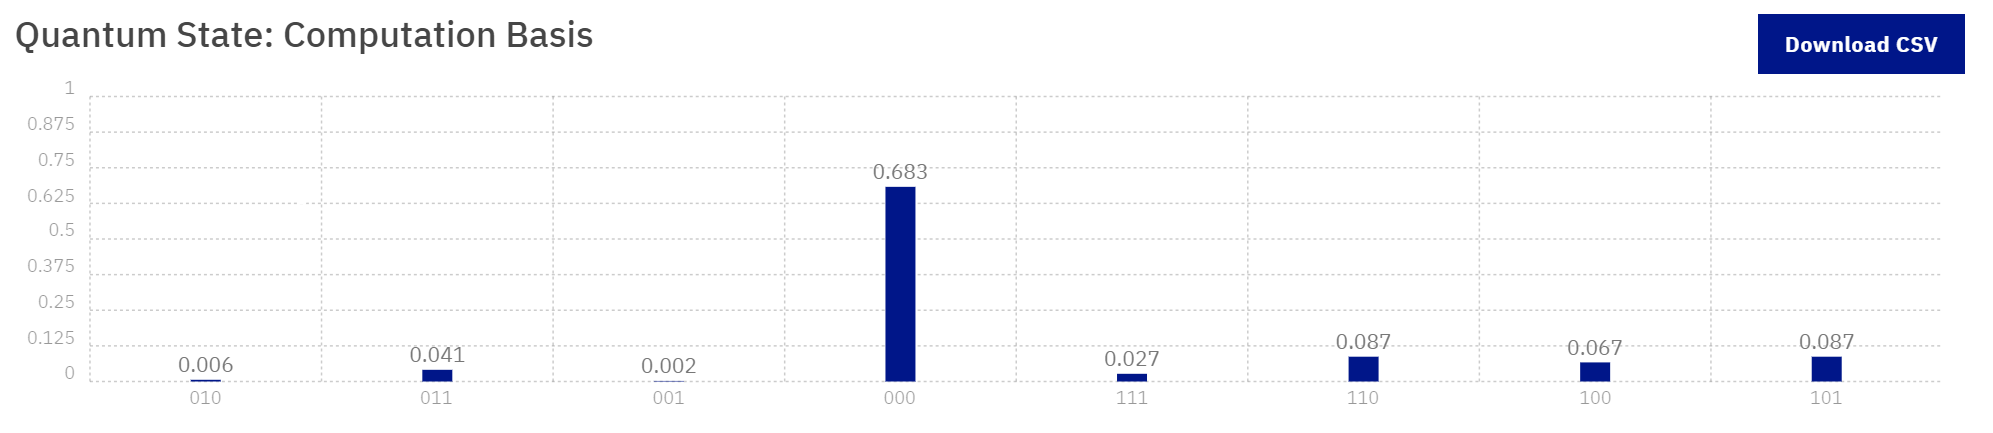

In [17]:
Image(filename="error_correction_files/error_correction_40_0.png", width=900, height=600)

## Multiple Cycles

We tried the same sample code as above but run the Oracle-Amplification cycle twice, and we succeeded in getting higher probability for reaching the correct state 000

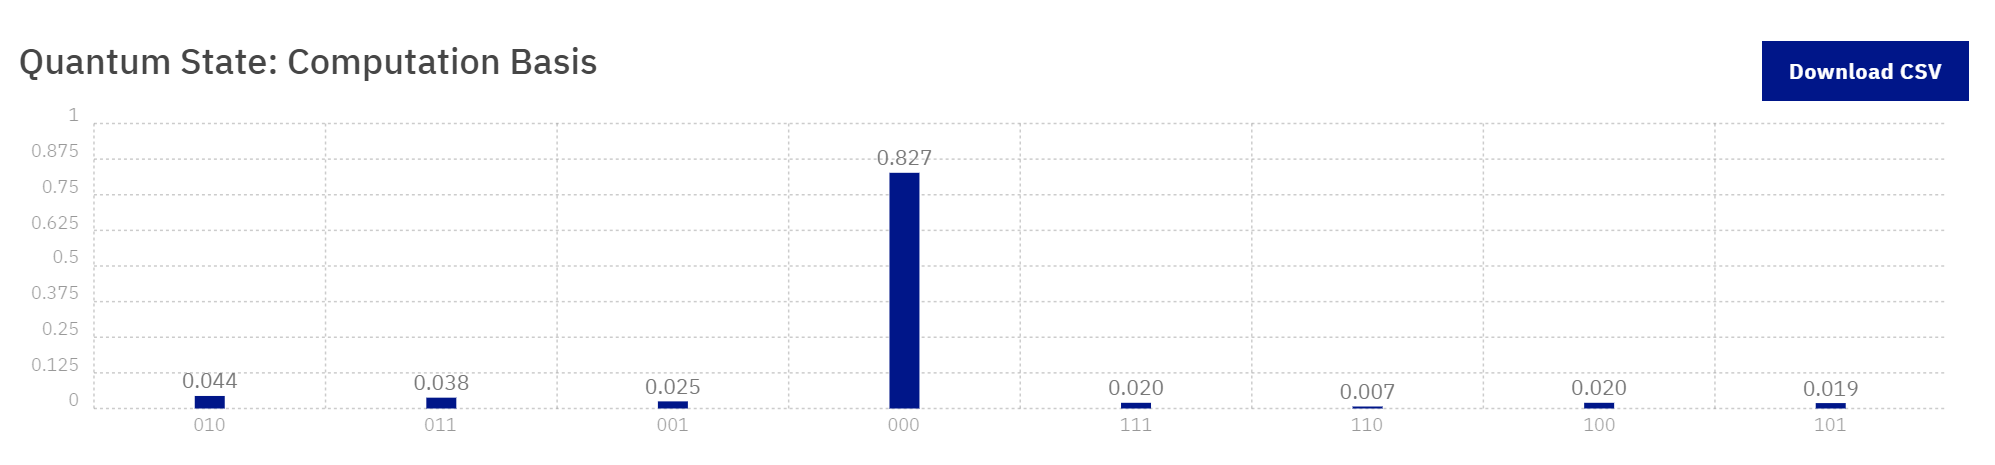

In [18]:
Image(filename="error_correction_files/error_correction_43_0.png", width=900, height=450)

## Reference

Figgatt, C., Maslov, D., Landsman, K. A., Linke, N. M., Debnath, S., & Monroe, C. (2017). Complete 3-Qubit Grover search on a programmable quantum computer. Nature Communications, 8(1). doi:10.1038/s41467-017-01904-7

Barnes, E., Arenz, C., Pitchford, A., & Economou, S. E. (2017). Fast microwave-driven three-qubit gates for cavity-coupled superconducting qubits. Physical Review B, 96(2). doi:10.1103/physrevb.96.024504

Grovers Algorithm. (n.d.). Retrieved March 29, 2018, from https://www.qiskit.org/ibmqx-user-guides/full-user-guide/004-Quantum_Algorithms/070-Grovers_Algorithm.html